# Post-training calibration

Consider the case where an additional dataset is obtained after the training/sampling is complete. Instead of combining the training and additional dataset together to perform training/sampling again, which may not be ideal for some reasons, e.g., fitting a model is extremely computationally expensive, we can do calibrations.

In this jupyter notebook, we focus on regression task on $$y = x + 1.5 \sin(4\pi x)$$

In [1]:
import neuraluq as neuq
import neuraluq.variables as neuq_vars
from neuraluq.config import tf

import numpy as np
import scipy.io as sio
import matplotlib.pyplot as plt

In [2]:
def load_data():
    data = sio.loadmat("../../dataset/calibration.mat")
    x_test, u_test = data["x_test"], data["u_test"]
    x_train, u_train = data["x_train"], data["u_train"]
    x_cal, u_cal = data["x_cal"], data["u_cal"]
    return x_train, u_train, x_cal, u_cal, x_test, u_test


x_train, u_train, x_cal, u_cal, x_test, u_test = load_data()

#### Training

First, suppose we don't have calibration data, we use a BNN with one-hidden layer to approximate the training data. As shown below, the BNN fits the data well, but the uncertainty estimate is bad: the uncertainty does not bound the error.

In [3]:
process = neuq.process.Process(
    surrogate=neuq.surrogates.FNN(layers=[1, 50, 1]),
    prior=neuq.variables.fnn.Samplable(layers=[1, 50, 1], mean=0, sigma=1),
)
likelihood = neuq.likelihoods.Normal(
    inputs=x_train,
    targets=u_train,
    processes=[process],
    sigma=0.1,
)
model = neuq.models.Model(
    processes=[process], likelihoods=[likelihood],
)

method = neuq.inferences.HMC(
    num_samples=1000,
    num_burnin=1000,
    init_time_step=0.1,
    leapfrog_step=50,
    seed=None,
)
model.compile(method)

samples, results = model.run()
print(np.mean(results))

Supporting backend tensorflow.compat.v1

Compiling a MCMC method

sampling from posterior distribution ...

Finished sampling from posterior distribution ...

0.647


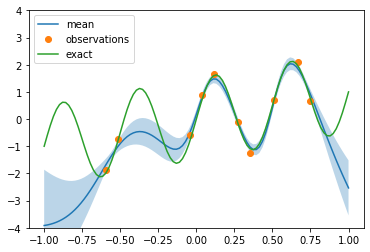

In [4]:
u_pred, = model.predict(
    x_test.reshape([-1, 1]), samples, [process]
)
mu = np.mean(u_pred, axis=0)
std = np.std(u_pred, axis=0)

plt.plot(x_test.flatten(), mu.flatten(), label='mean')
plt.fill_between(x_test.flatten(), (mu+2*std).flatten(), (mu-2*std).flatten(), alpha=0.3)
plt.plot(x_train, u_train, 'o', label='observations')
plt.plot(x_test, u_test, label='exact')
plt.legend()
plt.ylim([-4, 4])

plt.show()

#### Calibrations

Now we use the additional dataset to calibrate the uncertainty. As shown below, the uncertainty is calibrated such that it is able to bound the error, even for region where neither training data nor calibration data is presented.

In [5]:
u_pred, = model.predict(
    x_cal.reshape([-1, 1]), samples, [process]
)

calibration_model = neuq.calibrations.CalibrationVar(
    targets=tf.constant(u_cal, tf.float32),
    predictions=tf.reduce_mean(u_pred, axis=0),
    stds=tf.math.reduce_std(u_pred, axis=0),
    optimizer=tf.train.AdamOptimizer(1e-3),
)
s = calibration_model.calibrate(num_iterations=20000, sess=model.sess, display_every=2000)

Iteration:  0 , loss:  55.761555
Iteration:  2000 , loss:  11.52133
Iteration:  4000 , loss:  10.690694
Iteration:  6000 , loss:  10.687571
Iteration:  8000 , loss:  10.687571
Iteration:  10000 , loss:  10.68757
Iteration:  12000 , loss:  10.68757
Iteration:  14000 , loss:  10.687571
Iteration:  16000 , loss:  10.687571
Iteration:  18000 , loss:  10.687571


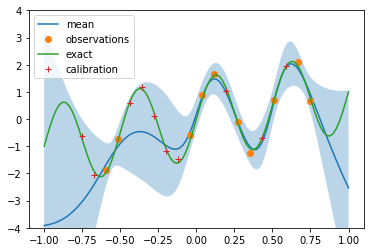

In [6]:
u_pred, = model.predict(
    x_test.reshape([-1, 1]), samples, [process]
)
mu = np.mean(u_pred, axis=0)
std = np.std(u_pred, axis=0) * s

plt.plot(x_test.flatten(), mu.flatten(), label='mean')
plt.fill_between(x_test.flatten(), (mu+2*std).flatten(), (mu-2*std).flatten(), alpha=0.3)
plt.plot(x_train, u_train, 'o', label='observations')
plt.plot(x_test, u_test, label='exact')
plt.plot(x_cal, u_cal, '+', label='calibration')
plt.legend()
plt.ylim([-4, 4])
plt.show()

#### What if calibration data is used for training?

A natural question is: is calibration necessary? What happens if we use the calibration data for training as well? As shown below, the predicted mean is of course more accurate, which is certain because we have more data. But uncertainy for region without any data is still bad. The predicted uncertainty here indicates that we should trust the prediction for region where there is no data, which is clearly wrong. $\textbf{In terms of uncertainty}$, for the same model we use so far, using the additional dataset for calibration is clearly a better choice, than using it for training.

In [7]:
x_new_train = np.concatenate([x_train, x_cal], axis=0)
u_new_train = np.concatenate([u_train, u_cal], axis=0)
likelihood = neuq.likelihoods.Normal(
    inputs=x_new_train,
    targets=u_new_train,
    processes=[process],
    sigma=0.1,
)
model.likelihoods = [likelihood]
model.compile(method)

Compiling a MCMC method



In [8]:
samples, results = model.run()
print(np.mean(results))

sampling from posterior distribution ...

Finished sampling from posterior distribution ...

0.537


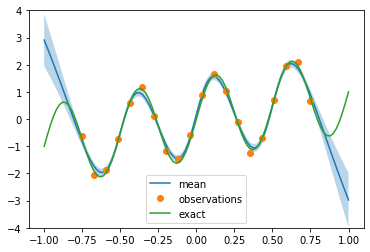

In [9]:
u_pred, = model.predict(x_test.reshape([-1, 1]), samples, [process])
mu = np.mean(u_pred, axis=0)
std = np.std(u_pred, axis=0)

plt.plot(x_test.flatten(), mu.flatten(), label='mean')
plt.fill_between(x_test.flatten(), (mu+2*std).flatten(), (mu-2*std).flatten(), alpha=0.3)
plt.plot(x_new_train, u_new_train, 'o', label='observations')
plt.plot(x_test, u_test, label='exact')
plt.legend()
plt.ylim([-4, 4])
plt.show()

#### Why?

It is against the intuition that more data for training could bring worse in estimate, even for uncertainty estimate. Generally, in the field of data science, it is always the case that more data we have, the better the prediction is. In the following, we show empirically one of the explanations for why it is not the case in above. The inexpressive neural network model seems to take the blame. With a larger and deeper network, everything returns to normal.

We don't discuss or argue the merits and the necessity of calibrations.

In [10]:
# deeper and larger neural network for the model
process = neuq.process.Process(
    surrogate=neuq.surrogates.FNN(layers=[1, 50, 50, 1]),
    prior=neuq.variables.fnn.Samplable(layers=[1, 50, 50, 1], mean=0, sigma=1),
)
likelihood = neuq.likelihoods.Normal(
    inputs=x_new_train,
    targets=u_new_train,
    processes=[process],
    sigma=0.1,
)
model = neuq.models.Model(
    processes=[process], likelihoods=[likelihood],
)
model.compile(method)

samples, results = model.run()
print(np.mean(results))

Supporting backend tensorflow.compat.v1

Compiling a MCMC method

sampling from posterior distribution ...

Finished sampling from posterior distribution ...

0.471


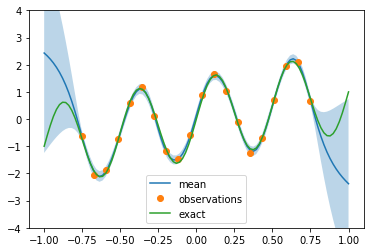

In [11]:
u_pred, = model.predict(
    x_test.reshape([-1, 1]), samples, [process]
)
mu = np.mean(u_pred, axis=0)
std = np.std(u_pred, axis=0)

plt.plot(x_test.flatten(), mu.flatten(), label='mean')
plt.fill_between(x_test.flatten(), (mu+2*std).flatten(), (mu-2*std).flatten(), alpha=0.3)
plt.plot(x_new_train, u_new_train, 'o', label='observations')
plt.plot(x_test, u_test, label='exact')
plt.legend()
plt.ylim([-4, 4])
plt.show()

#### Active learning, by adding one measurements

Now, we move to another topic: active learning. In this case, we wish to use the predicted uncertainty to guide us for further sampling. The spirit is, we know the existing dataset is not enough to give trustworthy prediction for some region, and we want to locate the place where the uncertainty is the largest, so that adding more measurements will suppress the uncertainty to make the prediction less uncertain.

In [12]:
process = neuq.process.Process(
    surrogate=neuq.surrogates.FNN(layers=[1, 50, 50, 1]),
    prior=neuq.variables.fnn.Samplable(layers=[1, 50, 50, 1], mean=0, sigma=1),
)
likelihood = neuq.likelihoods.Normal(
    inputs=x_train,
    targets=u_train,
    processes=[process],
    sigma=0.1,
)
model = neuq.models.Model(
    processes=[process], likelihoods=[likelihood],
)

method = neuq.inferences.HMC(
    num_samples=1000,
    num_burnin=1000,
    init_time_step=0.1,
    leapfrog_step=50,
    seed=None,
)
model.compile(method)

samples, results = model.run()
print(np.mean(results))

Supporting backend tensorflow.compat.v1

Compiling a MCMC method

sampling from posterior distribution ...

Finished sampling from posterior distribution ...

0.61


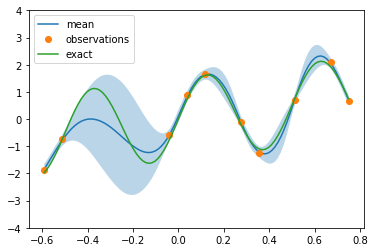

In [13]:
x_test = np.linspace(np.min(x_train), np.max(x_train), 100).reshape([-1, 1])
u_test = x_test + 1.5 * np.sin(4*np.pi*x_test)

u_pred, = model.predict(
    x_test.reshape([-1, 1]), samples, [process]
)
mu = np.mean(u_pred, axis=0)
std = np.std(u_pred, axis=0)

plt.plot(x_test.flatten(), mu.flatten(), label='mean')
plt.fill_between(x_test.flatten(), (mu+2*std).flatten(), (mu-2*std).flatten(), alpha=0.3)
plt.plot(x_train, u_train, 'o', label='observations')
plt.plot(x_test, u_test, label='exact')
plt.legend()
plt.ylim([-4, 4])
plt.show()

In [14]:
most_uncertain_id = np.argmax(std)
most_uncertain_x = x_test[most_uncertain_id].reshape([-1, 1])
most_uncertain_u = u_test[most_uncertain_id].reshape([-1, 1])

In [15]:
x_new_train = np.concatenate([x_train, most_uncertain_x], axis=0)
u_new_train = np.concatenate([u_train, most_uncertain_u], axis=0)
likelihood = neuq.likelihoods.Normal(
    inputs=x_new_train,
    targets=u_new_train,
    processes=[process],
    sigma=0.1,
)

model.likelihoods = [likelihood]
model.compile(method)

samples, results = model.run()
print(np.mean(results))

Compiling a MCMC method

sampling from posterior distribution ...

Finished sampling from posterior distribution ...

0.505


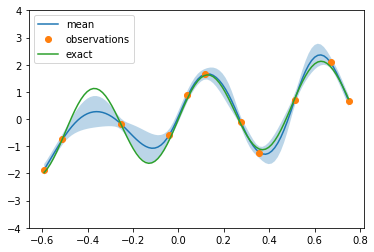

In [16]:
u_pred, = model.predict(
    x_test.reshape([-1, 1]), samples, [process]
)
mu = np.mean(u_pred, axis=0)
std = np.std(u_pred, axis=0)

plt.plot(x_test.flatten(), mu.flatten(), label='mean')
plt.fill_between(x_test.flatten(), (mu+2*std).flatten(), (mu-2*std).flatten(), alpha=0.3)
plt.plot(x_new_train, u_new_train, 'o', label='observations')
plt.plot(x_test, u_test, label='exact')
plt.legend()
plt.ylim([-4, 4])
plt.show()